In [18]:
#!pip install smopy

In [19]:
import networkx as nx
import numpy as np
import pandas as pd
import json
import smopy
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = mpl.rcParams['savefig.dpi'] = 300

In [20]:
g = nx.read_shp("data/tl_2013_06_prisecroads.shp")

In [21]:
sg = list(nx.connected_component_subgraphs(g.to_undirected()))[0]
len(sg)

4

In [22]:
pos0 = (36.6026, -121.9026)
pos1 = (34.0569, -118.2427)

In [23]:
def get_path(n0, n1):
    """If n0 and n1 are connected nodes in the graph, this function
    return an array of point coordinates along the road linking
    these two nodes."""
    return np.array(json.loads(sg[n0][n1]['Json'])['coordinates'])

In [24]:
EARTH_R = 6372.8
def geocalc(lat0, lon0, lat1, lon1):
    """Return the distance (in km) between two points in 
    geographical coordinates."""
    lat0 = np.radians(lat0)
    lon0 = np.radians(lon0)
    lat1 = np.radians(lat1)
    lon1 = np.radians(lon1)
    dlon = lon0 - lon1
    y = np.sqrt(
        (np.cos(lat1) * np.sin(dlon)) ** 2
         + (np.cos(lat0) * np.sin(lat1) 
         - np.sin(lat0) * np.cos(lat1) * np.cos(dlon)) ** 2)
    x = np.sin(lat0) * np.sin(lat1) + \
        np.cos(lat0) * np.cos(lat1) * np.cos(dlon)
    c = np.arctan2(y, x)
    return EARTH_R * c

In [25]:
def get_path_length(path):
    return np.sum(geocalc(path[1:,0], path[1:,1],
                          path[:-1,0], path[:-1,1]))

In [26]:
# Compute the length of the road segments.
for n0, n1 in sg.edges_iter():
    path = get_path(n0, n1)
    distance = get_path_length(path)
    sg.edge[n0][n1]['distance'] = distance

In [27]:
nodes = np.array(sg.nodes())
# Get the closest nodes in the graph.
pos0_i = np.argmin(np.sum((nodes[:,::-1] - pos0)**2, axis=1))
pos1_i = np.argmin(np.sum((nodes[:,::-1] - pos1)**2, axis=1))

In [28]:
# Compute the shortest path.
path = nx.shortest_path(sg, 
                        source=tuple(nodes[pos0_i]), 
                        target=tuple(nodes[pos1_i]),
                        weight='distance')
len(path)

2

In [29]:
roads = pd.DataFrame([sg.edge[path[i]][path[i + 1]] 
                      for i in range(len(path) - 1)], 
                     columns=['FULLNAME', 'MTFCC', 
                              'RTTYP', 'distance'])
roads

,FULLNAME,MTFCC,RTTYP,distance
0,Ave 21,S1200,M,1.855707


In [30]:
roads['distance'].sum()

1.85570731368565

In [31]:
map = smopy.Map(pos0, pos1, z=7, margin=.1)

In [32]:
def get_full_path(path):
    """Return the positions along a path."""
    p_list = []
    curp = None
    for i in range(len(path)-1):
        p = get_path(path[i], path[i+1])
        if curp is None:
            curp = p
        if np.sum((p[0]-curp)**2) > np.sum((p[-1]-curp)**2):
            p = p[::-1,:]
        p_list.append(p)
        curp = p[-1]
    return np.vstack(p_list)

In [33]:
linepath = get_full_path(path)
x, y = map.to_pixels(linepath[:,1], linepath[:,0])

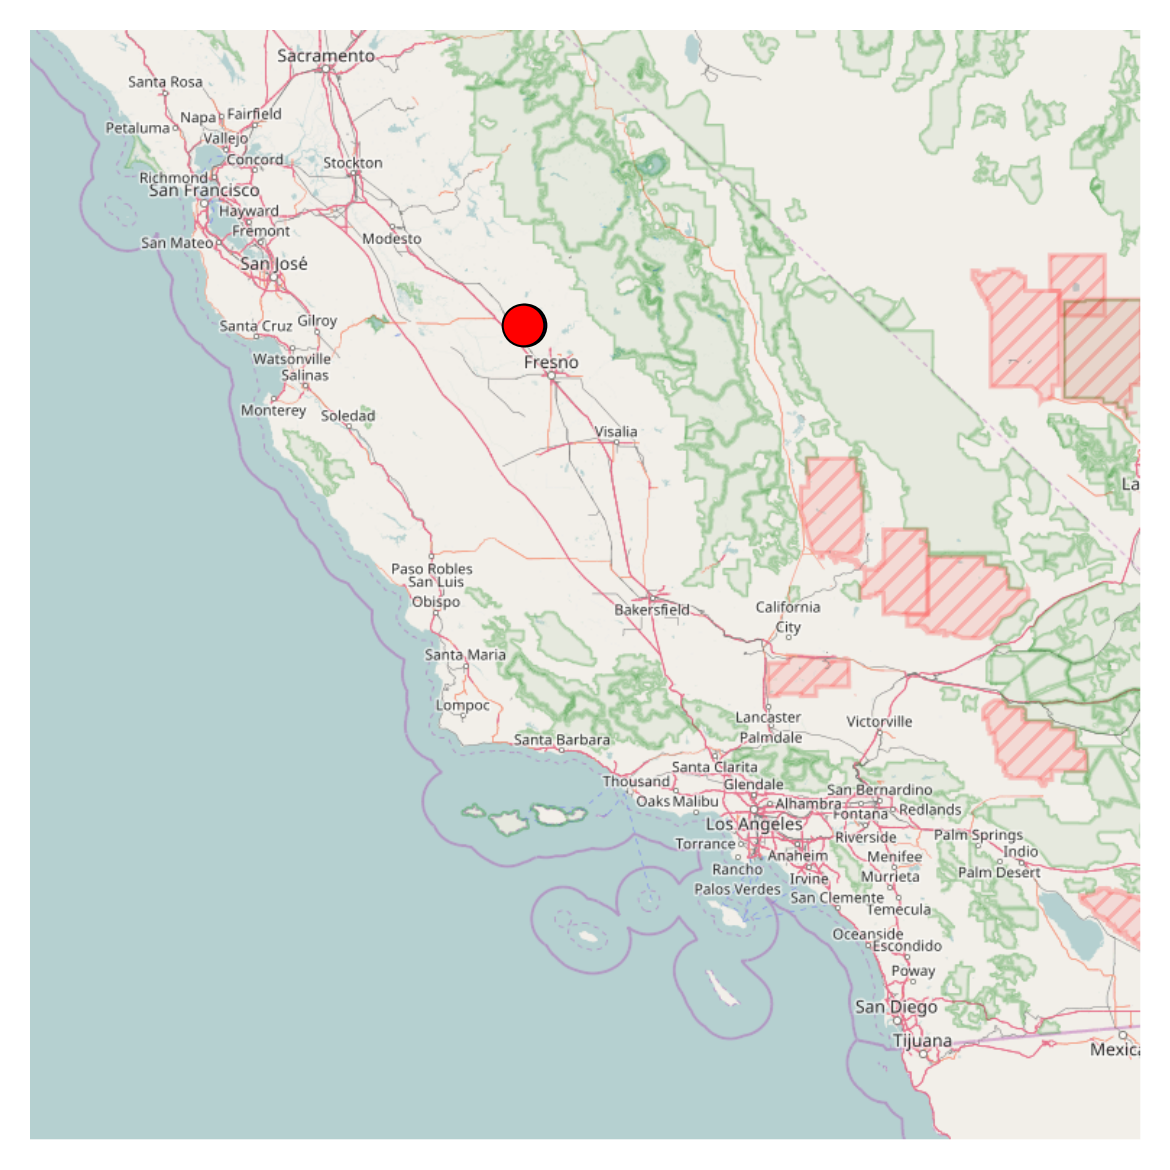

In [35]:
plt.figure(figsize=(3,3));
map.show_mpl();
# Plot the itinerary.
plt.plot(x, y, '-k', lw=1.5);
# Mark our two positions.
plt.plot(x[0], y[0], 'ob', ms=10);
plt.plot(x[-1], y[-1], 'or', ms=10);